# Prerequisites

## Modules

In [1]:
# Modules are available in conda environment with name: icet
# conda activate icet

import ase
from ase.io import read as ASEread
from ase.io.vasp import write_vasp
from ase.db import connect
from ase.cell import Cell
from ase.neighborlist import NewPrimitiveNeighborList
from ase.build import make_supercell

import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import colormaps
import glob
import sys
import os
import random
import shutil

import icet
from icet import ClusterSpace, StructureContainer, ClusterExpansion
from trainstation import CrossValidationEstimator
from icet.tools import enumerate_structures
from icet.tools.structure_generation import generate_sqs_by_enumeration

try:
    import seaborn as sns
    sns.set_context('notebook')
except ImportError:
    print('sad')
    
import subprocess

import datetime

## Misc Functions

In [2]:
# Stop message
def jupyter_stop(ErrorMessage="User-defined stop via jupyter_stop() function"):
    """
    User defined stop function, similar to exit(). Mostly for testing purpose or to 
    avoid overwriting of already generated data.
    """
    raise SystemExit(ErrorMessage)

## CE Functions

## Reorder Atoms

In [3]:
# S only in this list to 'trick' the structure enumeration
# S as extra Nickel
atomic_label2number = {"Li" :  3,
                       "O"  :  8,
                       "S"  : 16,
                       "Ni" : 28}

atomic_number2label = { 3 : "Li",
                        8 :  "O",
                       16 :  "S",
                       28 :  "Ni"}


def order_atoms(atoms,order=["Li","Ni","O"]):
    
    # get old positions and atomic numbers
    old_positions       = atoms.get_positions()
    old_atomic_number   = atoms.get_atomic_numbers()
    
    # create empty dict for all types
    atomic_pos_dict = {}
    for sym in order:
        atomic_pos_dict[sym] = []
    
    # append positions to dict 
    for num, pos in zip(old_atomic_number, old_positions):
        atomic_pos_dict[atomic_number2label[num]].append(pos)
    
    # put together the new ordered positions and atomic numbers
    new_positions = []
    new_atomic_numbers = []
    for sym in order:
        new_positions.extend(atomic_pos_dict[sym])
        new_atomic_numbers.extend( [ atomic_label2number[sym] ] * len(atomic_pos_dict[sym]) )
    
    # copy original atoms object and modify it
    copy_atoms = atoms.copy()
    copy_atoms.set_positions(new_positions)
    copy_atoms.set_atomic_numbers(new_atomic_numbers)
    
    return copy_atoms


# Collect data

In [4]:
### Get the reference energies of LiNiO2 and NiO2 normed per unit cell
LiNiO2 = ASEread("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/CE_database_Marcel/02_enumerate_P21c_0-4fu/0001_finished_approved/run_final_approved/OUTCAR")
E_ref_LiNiO2_per_O2 = LiNiO2.get_potential_energy() / LiNiO2.get_chemical_symbols().count("O") * 2 #or per Ni in case of no extra Ni

NiO2   = ASEread("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/CE_database_Marcel/02_enumerate_P21c_0-4fu/0003_finished_approved/run_final_approved/OUTCAR")
E_ref_NiO2_per_O2   = NiO2.get_potential_energy() / NiO2.get_chemical_symbols().count("O") * 2 #or per Ni in case of no extra Ni

## Own enumerated structures based on P21/c

In [5]:
#Li verteilung ohne trans
atoms_for_training_from_own_enumerated_structures = []
H_o_M_for_training_from_own_enumerated_structures = []

# Get all the outcars of interest
outcars_for_training_from_own_enumerated_structures= sorted(glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/CE_database_Marcel/02_enumerate_P21c_0-4fu/0*_finished_approved/run_final_approved/OUTCAR"))

# Iterate over them
for outcar in outcars_for_training_from_own_enumerated_structures:
    
    # get atoms object
    atoms = ASEread(outcar, index=":")
    
    # Compute total heat of mixing 
    Li_count = atoms[-1].get_chemical_symbols().count("Li")
    O_count  = atoms[-1].get_chemical_symbols().count("O")
    H_o_M    = atoms[-1].get_potential_energy() - Li_count * E_ref_LiNiO2_per_O2 - (O_count/2 - Li_count) * E_ref_NiO2_per_O2

    # Append data...     
    # ... but to make mapping easier take the originally generated structures instead of the relaxed ones
    ref = "/".join(outcar.split("/")[:-2]) + "/POSCAR_enumerated"
    atoms_for_training_from_own_enumerated_structures.append(ASEread(ref))
    #refactor to HOM per Atom
    H_o_M_for_training_from_own_enumerated_structures.append( H_o_M / len(atoms[-1]) )

## Markus low energy CE data

In [6]:
# Basic setups

def get_fit_data(prim, chemical_symbols, cutoffs, energy_list, atoms_ref_list, outcar_list, position_tolerance, symprec, tol_positions):
    """
    Construct cluster space and structure container for the given cutoffs
    and return the fit matrix along with the target energies
    """
    # stepsize to print update of training:
    stepsize = int(0.1*len(outcar_list))
    
    # Collect the mapped structures
    mapped_structures = []
    
    # Set up Clusterspace
    cs = ClusterSpace(structure=prim,
                      cutoffs=cutoffs,
                      chemical_symbols=chemical_symbols,
                      position_tolerance=position_tolerance,
                      symprec=symprec)
    
    #print(cs)
    
    # Set up StructureContainer with the previsouly generated ClusterSpace
    sc = StructureContainer(cluster_space=cs)
    
    # Fill the StructureContainer
    for i, (outcar, E, at_ref) in enumerate(zip(outcar_list, energy_list, atoms_ref_list)):
        
        # print update of training
        if i % stepsize == 0:
            print(f"Computing structure {i} of {len(outcar_list)} ({i/len(outcar_list):.1%})   {datetime.datetime.now()}")
        
        
        # Read the OUTCAR [by default last step is used] and get energy
        #at     = ASEread(outcar)
        #total_energy = at.get_potential_energy() # total_energy = atoms.get_potential_energy(force_consistent=True)
        
        # Map the enumerated structure to the primitive cell, add it to cluster space with the energy of the properly relaxed system
        try:
            mapped_atoms, info = icet.tools.map_structure_to_reference(structure=at_ref, 
                                                             reference=prim, 
                                                             inert_species=["O"], 
                                                             tol_positions=tol_positions, 
                                                             suppress_warnings=False, 
                                                             assume_no_cell_relaxation=False)
            mapped_structures.append(mapped_atoms)

            sc.add_structure(structure=mapped_atoms,
                     properties={'Total Energy': E},
                     user_tag = outcar,
                     sanity_check=True,
                     )
        
        except ValueError as err:
            print(f"Mapping Error with {outcar}")
            print(f"Note: Possibly a different structure was used for the mapping!")
            print("Original Error Message:")
            print(err , "\n")
            

            
    print(f"len(cs) = {len(cs)}")
    
    return sc.get_fit_data(key='Total Energy'), mapped_structures


def get_A_y(prim, chemical_symbols, cutoffs, energy_list, atoms_ref_list, outcar_list, position_tolerance, symprec, tol_positions):
    return get_fit_data(prim, chemical_symbols, cutoffs, energy_list, atoms_ref_list, outcar_list, position_tolerance, symprec, tol_positions)



def get_row(cve, alpha=None):
    row = dict()
    row['rmse_validation'] = cve.rmse_validation
    row['rmse_train'] = cve.rmse_train
    row['BIC'] = cve.model.BIC
    row['n_parameters'] = cve.n_parameters
    row['n_nonzero_parameters'] = cve.n_nonzero_parameters
    
    if alpha != None:
        row['alpha'] = alpha
    
    return row


def train_ce(prim, chemical_symbols, cutoffs, energy_list, atoms_ref_list, outcar_list, position_tolerance, symprec, tol_positions, fit_method):
    """
    Train a cluster expansion with the given cutoffs and return fit metrics of the obtained model.
    prim: ase atoms object, its the primitive structure that the CE lives on
    chemical_symbols: List of the possible atoms types on the different sites of prim
    cutoffs: cutoffs for the 2-body, 3-body, ... terms
    atoms_list: list of all the atoms objects to use for training/testing
    outcar_list : list with paths (strings) of the corresponding atoms objects
    fit_method examples with additional options (to be implemented at a later point): 
        fit_method='rfe'
        fit_method='ardr', threshold_lambda=4e5
        fit_method='ardr', line_scan=True
        fit_method='lasso'
        fit_method='least-squares'
    """
    (A, y), mapped_structures = get_fit_data(prim, chemical_symbols, cutoffs, energy_list, atoms_ref_list, outcar_list, position_tolerance, symprec, tol_positions)
    n_splits=10
    if fit_method == 'ardr-lambda':
        cve = CrossValidationEstimator((A, y), fit_method='ardr', threshold_lambda=1000, validation_method='shuffle-split', n_splits=n_splits)
    elif fit_method == 'ardr-lineScan':
        cve = CrossValidationEstimator((A, y), fit_method='ardr', line_scan=True, validation_method='shuffle-split', n_splits=n_splits)
    else:
        cve = CrossValidationEstimator((A, y), fit_method=fit_method, validation_method='shuffle-split', n_splits=n_splits)
    print(f'starting validation with {fit_method} algorithm  {datetime.datetime.now()}')
    cve.validate()
    cve.train()

    row = get_row(cve)
    
    return row

def prevent_overwrite(file_name,add = ''):
    if os.path.exists(file_name+add):
        if add != '':
            n = int(add)
            n += 1
        else:
            n = 1  
        add = str(n)
        file_name = prevent_overwrite(file_name,add)
        add = ''
    return file_name + add

In [7]:
# The following code takes Markus' relaxed structures and rotates them around the ccartesian z axis to fit the primitive structure we are using
# Does not need to be run again
# REMOVED error so it can run through until optimization

In [8]:
#Li verteilung ohne trans
# Compare Markus last step energy and volume with the ones re-relaxed from me
# To this end, use the README files where 

atoms_for_training_from_Markus_low_energy_structures   = []
H_o_M_for_training_from_Markus_low_energy_structures   = []
outcars_for_training_from_Markus_low_energy_structures = []

READMEs = glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/CE_database_Marcel/03_Markus_approved_low_energy_data/*/README_original_path_from_Markus")

for README in READMEs:
    
    if os.path.isdir(README.replace("README_original_path_from_Markus","run_final")):
    
        # get the transformed CONTCAR to enable correct mapped to our prim structure later
        # Only for the 2 structures that made problems, take the original (rotated) POSCAR to enable mapping later
        if "re-relax_Markus038_finished" in README or "re-relax_Markus115_finished" in README:
            with open(README, "r") as f:
                line = f.readlines()[0]
            transformed_contcar = "/".join(line.split("/")[0:-1]) + "/run01/POSCAR_rotated.vasp" 
        else:
            transformed_contcar = README.replace("README_original_path_from_Markus","run_final/CONTCAR_rotated.vasp")
        atoms_transformed_contcar = ASEread(transformed_contcar)
        atoms_for_training_from_Markus_low_energy_structures.append(atoms_transformed_contcar)
        
        # get the outcar from the relaxation to get the energy
        outcar = README.replace("README_original_path_from_Markus","run_final/OUTCAR")
        outcars_for_training_from_Markus_low_energy_structures.append(outcar)
        atoms = ASEread(outcar, index=":")

        # Compute heat of mixing and per atom
        Li_count = atoms[-1].get_chemical_symbols().count("Li")
        O_count  = atoms[-1].get_chemical_symbols().count("O")
        H_o_M    = atoms[-1].get_potential_energy() - Li_count * E_ref_LiNiO2_per_O2 - (O_count/2 - Li_count) * E_ref_NiO2_per_O2    
        H_o_M_for_training_from_Markus_low_energy_structures.append( H_o_M / len(atoms[-1]) )
        

## NEB initial and final images (without Ni_Li)

In [9]:
#Li verteilung ohne trans
atoms_for_training_NEB_initial_and_final_images = []
H_o_M_for_training_NEB_initial_and_final_images = []

# Find the ordered ones from 0250, 0500 and 0750 first
outcars_for_training_NEB_initial_and_final_images  = glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0250/image*/02_scan/*final/OUTCAR", recursive=True)
outcars_for_training_NEB_initial_and_final_images += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0500/image*/02_scan/*final/OUTCAR", recursive=True)
outcars_for_training_NEB_initial_and_final_images += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0750/image*/02_scan/*final/OUTCAR", recursive=True)

# and the ones from the random structures
outcars_for_training_NEB_initial_and_final_images += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0*random*/01_initial_structure/02_scan/*final/OUTCAR", recursive=True)
outcars_for_training_NEB_initial_and_final_images += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0*random*/02_odh/image*/02_scan/*final/OUTCAR", recursive=True)
outcars_for_training_NEB_initial_and_final_images += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0*random*/03_tsh/image*/02_scan/*final/OUTCAR", recursive=True)
outcars_for_training_NEB_initial_and_final_images += glob.glob("/nfshome/sadowski/work/LiNiO2_data_base_Sabrina/DFT_database/NEBs_Marcel/0*random*/04_double_tsh/image*/02_scan/*final/OUTCAR", recursive=True)

# Iterate over OUTCARs
for OUTCAR in outcars_for_training_NEB_initial_and_final_images:
    
    # get the atoms object
    atoms = ASEread(OUTCAR, index=":") 
    
    # Compute heat of mixing and per atom
    Li_count = atoms[-1].get_chemical_symbols().count("Li")
    O_count  = atoms[-1].get_chemical_symbols().count("O")
    H_o_M    = atoms[-1].get_potential_energy() - Li_count * E_ref_LiNiO2_per_O2 - (O_count/2 - Li_count) * E_ref_NiO2_per_O2
        
    # append them to the lists
    atoms_for_training_NEB_initial_and_final_images.append(atoms[-1])
    H_o_M_for_training_NEB_initial_and_final_images.append( H_o_M / len(atoms[-1]) )

## NEB transition states

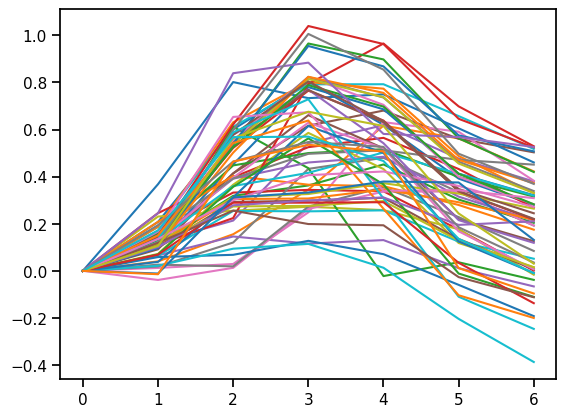

In [10]:
#Li-trans
fig, ax = plt.subplots()

atoms_for_training_NEB_transition_states = []
H_o_M_for_training_NEB_transition_states = []
paths_for_training_NEB_transition_states = []

# the ones generated manually (0250, 0500, 0750)
paths_for_training_NEB_transition_states  = glob.glob("/nfshome/winkelmann/ARL/NEBs_Marcel/0250/NEB_*_finished/run_final")
paths_for_training_NEB_transition_states += glob.glob("/nfshome/winkelmann/ARL/NEBs_Marcel/0500/NEB_*_finished/run_final")
paths_for_training_NEB_transition_states += glob.glob("/nfshome/winkelmann/ARL/NEBs_Marcel/0750/NEB_*_finished/run_final")

# the random ones
paths_for_training_NEB_transition_states += glob.glob("/nfshome/winkelmann/ARL/NEBs_Marcel/0*random*/02_odh/NEB_*/run_final")
paths_for_training_NEB_transition_states += glob.glob("/nfshome/winkelmann/ARL/NEBs_Marcel/0*random*/03_tsh/NEB_*/run_final")
paths_for_training_NEB_transition_states += glob.glob("/nfshome/winkelmann/ARL/NEBs_Marcel/0*random*/04_double_tsh/NEB_*/run_final")

# Iterate over all run_final folders
for path in paths_for_training_NEB_transition_states:
    
    # Check the energy along the path. Use initial and final energies from the corresponding relaxed structures + the last steps of the 
    # optimized intermediate images
    energies = []
    energies.append(ASEread(path.replace("run_final", "OUTCAR_initial_image")).get_potential_energy())
    for i in ["01", "02", "03", "04", "05"]:
        energies.append(ASEread(f"{path}/{i}/OUTCAR").get_potential_energy())
    energies.append(ASEread(path.replace("run_final", "OUTCAR_final_image")).get_potential_energy())
    ax.plot([0,1,2,3,4,5,6], np.array(energies)-energies[0])
    
    # For "Proper" paths, there should be maximum in energy !between! initial and final paths... ignore those where this is not the case
    index_highest_energy = energies.index(max(energies))
    
    if index_highest_energy == 0 or index_highest_energy == 6:
        print(f"Ignore {path}\n  ---> image {index_highest_energy} has highest energy!")
    
    else:    
        # get the interpolated middle points of the initially created, straight odh-type path to be used as ideal position for the CE training
        ideal_TS_structure_file = glob.glob(path.replace("run_final", "jochen_trans_image.vasp")) 
        ideal_TS_atoms = ASEread(ideal_TS_structure_file[0])
     
        atoms_for_training_NEB_transition_states.append(ideal_TS_atoms)
        
        # Compute heat of mixing per atom and append to list
        Li_count = ideal_TS_atoms.get_chemical_symbols().count("Li") + 1 # +1 for the jumping Li
        O_count  = ideal_TS_atoms.get_chemical_symbols().count("O")
        H_o_M    = max(energies) - Li_count * E_ref_LiNiO2_per_O2 - (O_count/2-Li_count) * E_ref_NiO2_per_O2
        H_o_M_for_training_NEB_transition_states.append( H_o_M / (len(ideal_TS_atoms) - 1) ) # -1 for Vac that is Ti
        
    


## Combine data

In [11]:
# combine the structures 
train_structures = ( atoms_for_training_from_own_enumerated_structures 
                    + atoms_for_training_from_Markus_low_energy_structures
                    + atoms_for_training_NEB_initial_and_final_images 
                    + atoms_for_training_NEB_transition_states 
             )

# ... and energies
train_H_o_M      = ( H_o_M_for_training_from_own_enumerated_structures 
                     + H_o_M_for_training_from_Markus_low_energy_structures
                     + H_o_M_for_training_NEB_initial_and_final_images 
                     + H_o_M_for_training_NEB_transition_states 
             )

# to be able to retrieve problematic files, keep the paths
file_location = ( outcars_for_training_from_own_enumerated_structures 
                + outcars_for_training_from_Markus_low_energy_structures 
                + outcars_for_training_NEB_initial_and_final_images 
                + paths_for_training_NEB_transition_states
                )
# calc and print how many non Ts and TS structures are used for training
no_nonTS_structures = len( outcars_for_training_from_own_enumerated_structures 
                           + outcars_for_training_from_Markus_low_energy_structures 
                           + outcars_for_training_NEB_initial_and_final_images)
no_TS_structures = len(paths_for_training_NEB_transition_states)

print('# nonTS-Structures:\t', no_nonTS_structures)
print('# TS-Structures:\t', no_TS_structures)


# nonTS-Structures:	 882
# TS-Structures:	 62


# Fitting of just the Li sublattice

without TS


<font color='red'> deleted traing of ardr_lambda </font>
just left the setting of the Clusterspace

<font color='red'> deleted code cell for calculating with the model with respect to the trained structure </font>
kept initalization of data[] (without predicted_energy)

<font color='red'> deleted code cell for plotting the ardr_lambda fitting vs reference data with respect to the diffrent data sets </font>

# First fitting for testing purposes of python implementation (no Ni_Li, but with transition states)

In [ ]:
# Read R-3m model of LiNiO2 in R-3m symmetry with transition states
prim_TS = ASEread("/nfshome/sadowski/work/LiNiO2_Sabrina/37_CE_for_Li_diffusion/00_LNO_R-3m.vasp")

print(prim_TS)
print(prim_TS.get_chemical_symbols())

In [ ]:
chemical_symbols_TS= [['Li', 'X', 'Ti'],   # Li sublattice will contain: Li and Vacancies (=X), later also Ni
                    ['Ni'],       # Ni sublattice will not be changed
                    ['O'],        # O  sublattice will not be changed
                    ['O']]        

Idee pickle here (als binärdaten speichern)

# Optimizing CE

## finding cutoffs
list possile cutoffs and define standard variables

In [ ]:
# read results cutoffs_noTS
best_cutoffs_noTS = {}
    
file = open('/nfshome/winkelmann/ARL/save/best_cutoffs_noTS','r')
file.readline()
lines = file.readlines()
file.close()
    
for line in lines:
    line = line.replace(' ', '')
    values = line.split(',')
    best_cutoffs_noTS[values[0]] = [float(values[1]), float(values[2]), float(values[3])]
    print('%14s:\t%s' % (values[0], best_cutoffs_noTS[values[0]]))

In [ ]:
import time as pytime

cutoff_vals = [2.84, 2.85, 4.93, 5.00, 5.69, 5.75, 6.42, 7.53, 7.57, 8.09] # till 8.09 - biggest cutoff so the transition stated doesnt see itself

position_tolerance = 0.01
symprec = 0.01
tol_positions=0.05

fit_methods = ['ardr-lambda', 'ardr-lineScan', 'rfe', 'lasso', 'least-squares', 'bayesian-ridge', 'elasticnet', 'omp', 'ridge', 'split-bregman']
records = {}
#todo: look at TS-mapped in ovito
#todo: try weighting TS --> not working       
#        #weighting TS-Structures higher
#        weights = np.ones(len(y))
#        for structure, weight in zip(train_structures, weights):
#            if structure in atoms_for_training_NEB_transition_states:
#                weight = 10
        

### pair cutoff

In [ ]:
save_file = prevent_overwrite('/nfshome/winkelmann/ARL/tmp/cutoffs_2_jochen_fit')
file_format = '%14s,\t%13s,\t%13s,\t%15s,\t%15s,\t%15s,\t%7s,\t%7s,\t%7s' + os.linesep
file = open(save_file,'w')
file.write(file_format % ('fit_method', 'cutoffs' , 'cutoff2', 'validation', 'train', 'BIC', 'number', 'nonzero','time'))
file.close()
for fit_method in fit_methods:
    records[fit_method] = []
    c2_vals = cutoff_vals
    for c2 in c2_vals:
        start_time = pytime.time()
        cutoffs = best_cutoffs_noTS[fit_method]
        cutoffs[0] = c2
        row = train_ce(prim=prim_TS,
                       chemical_symbols=chemical_symbols_TS,
                       cutoffs=cutoffs,
                       energy_list=train_H_o_M,
                       atoms_ref_list=train_structures,
                       outcar_list=file_location,
                       position_tolerance=position_tolerance,
                       symprec=symprec,
                       tol_positions=tol_positions,
                       fit_method=fit_method)
        records[fit_method].append({'c2': c2, **row})
        file = open(save_file, 'a')
        file.write(file_format % (fit_method, cutoffs, c2, row['rmse_validation'], row['rmse_train'], row['BIC'], row['n_parameters'], row['n_nonzero_parameters'], pytime.time()-start_time))
        file.close()                       

#Total number of Li-Li Bonds as function of cutoff (intra layer/inter layer):
#                       same Layer          next layer x2   second next layer x2
# 2.84    0  ( 0/ 0)    
# 2.85    6  ( 6/ 0)    first  (6)
# 4.93   12  (12/ 0)    second (6)
# 5.00   18  (12/ 6)                        first  (3) 
# 5.69   24  (18/ 6)    third  (6)
# 5.75   30  (18/12)                        second (3) 
# 6.42   42  (18/24)                        third  (6) 
# 7.53   54  (30/24)    fourth (12) 
# 7.57   66  (30/36)                        fourth (6) 
# 8.09   72  (30/42)                        fifth  (3) 
# 8.53   78  (36/42)    fifth  (6)
# 8.57   90  (36/54)                        sixth  (6) 
# 9.47   96  (36/60)                        seventh(3)
# 9.58  102  (36/60/6)                                      first  (3)
# 9.85  108  (42/60/6)  sixth  (6)          
# 9.89  120  (42/72/6)                      eigth  (6)
#10.00  126  (42/72/12)                                     second (3)
#10.26  138  (54/72/12) seventh(12)
#10.29  150  (54/84/12)                     ninth  (6)
#10.39  162  (54/84/24)                                     third  (6)
#11.10  174  (54/96/24)                     tenth(6)
#11.14  186  (54/96/36)                                     fourth(6)
#11.38  192  (60/96/36) eighth(6)
#11.50  198  (60/96/42)                                     fifth(3)
#11.76  210  (60/108/42)                    ninth(6)
#11.84  222  (60/108/54)                                    sixth(6)
#12.40  234  (72/108/54) ninth(12)
#12.42  252  (72/126/54)                    tenth(9)
#12.51  258  (72/126/60)                                    seventh(3)
#12.75  270  (72/138/60)                    eleventh(6)
#12.83  282  (72/138/72)                                    eighth(6)
#13.03  294  (84/138/72) tenth(12)
#13.14  306  (84/138/84)                                    ninth(6)
#13.66  318  (84/150/84)                    twelfth(6)
#13.74  330  (84/150/96)                                    tenth(6)
#13.96  336  (84/156/96)                    thiteenth(3)
#14.15  338  (84/156/96/2)                                                  first(1)


### triplett cutoff

In [ ]:
# read results cutoff2

best_cutoffs2 = {}
df2 = {}

for fit_method in fit_methods:
    df2[fit_method] = {'c2': [], 'rmse_validation': [], 'rmse_train': [], 'BIC': [], 'n_parameters': [],
                       'n_nonzero_parameters': []}
file = open('/nfshome/winkelmann/ARL/tmp/cutoffs_2_jochen_fit', 'r')
file.readline()
lines = file.readlines()

for line in lines:
    line = line.replace(' ', '')
    values = line.split(',')
    df2[values[0]]['c2'].append(float(values[4]))
    df2[values[0]]['rmse_validation'].append(float(values[5]))
    df2[values[0]]['rmse_train'].append(float(values[6]))
    df2[values[0]]['BIC'].append(float(values[7]))
    df2[values[0]]['n_parameters'].append(float(values[8]))
    df2[values[0]]['n_nonzero_parameters'].append(float(values[9]))

for fit_method in fit_methods:
    df2[fit_method] = pd.DataFrame(df2[fit_method])
    best_cutoffs2[fit_method] = df2[fit_method].c2[df2[fit_method].rmse_validation.idxmin()]

for key, cutoff in best_cutoffs2.items():
    print("%s: %s" % (key, cutoff))
max_cutoff2 = max(best_cutoffs2.values())
print('Max pair cutoff: %s' % max_cutoff2)

In [ ]:
# c3_vals = cutoff_vals[0: biggest min(rmse_validation) cutoff2]
# changed to 10 since everything above 8.09=cutoff_vals[9]

save_file = prevent_overwrite('/nfshome/winkelmann/ARL/tmp/cutoff_3_jochen_fit')
file_format = '%14s,\t%13s,\t%13s,\t%15s,\t%15s,\t%15s,\t%7s,\t%7s,\t%7s' + os.linesep
file = open(save_file, 'w')
file.write(file_format % ('fit_method','cutoffs', 'cutoff3', 'validation', 'train', 'BIC', 'number', 'nonzero','time'))
file.close()
for fit_method in fit_methods:
    records[fit_method] = []
    c3_opt_noTS_index = cutoff_vals.index(best_cutoffs_noTS[fit_method][1])
    c3_vals = cutoff_vals
    for c3 in c3_vals:
        #c2TS from here
        start_time = pytime.time()
        cutoffs = best_cutoffs_noTS[fit_method]
        cutoffs[0] = 8.09 #best Parameter for all useful C2-jochen-data
        cutoffs[1] = c3
        row = train_ce(prim=prim_TS,
                       chemical_symbols=chemical_symbols_TS,
                       cutoffs=cutoffs,
                       energy_list=train_H_o_M,
                       atoms_ref_list=train_structures,
                       outcar_list=file_location,
                       position_tolerance=position_tolerance,
                       symprec=symprec,
                       tol_positions=tol_positions,
                       fit_method=fit_method)
        records[fit_method].append({'c3': c3, **row})

        file = open(save_file, 'a')
        file.write(file_format % (fit_method, cutoffs, c3, row['rmse_validation'], row['rmse_train'], row['BIC'], row['n_parameters'], row['n_nonzero_parameters'], pytime.time()-start_time))
        file.close()

### quartett cutoff

In [ ]:
# read results cutoff3

best_cutoffs3 = {}
df3 = {}

for fit_method in fit_methods:
    df3[fit_method] = {'c3': [], 'rmse_validation': [], 'rmse_train': [], 'BIC': [], 'n_parameters': [],
                       'n_nonzero_parameters': []}
file = open('/nfshome/winkelmann/ARL/tmp/cutoffs_3_jochen_fit','r')
file.readline()
lines = file.readlines()
    
for line in lines:
    line = line.replace(' ', '')
    values = line.split(',')
    df3[values[0]]['c2'].append(float(values[4]))
    df3[values[0]]['rmse_validation'].append(float(values[5]))
    df3[values[0]]['rmse_train'].append(float(values[6]))
    df3[values[0]]['BIC'].append(float(values[7]))
    df3[values[0]]['n_parameters'].append(float(values[8]))
    df3[values[0]]['n_nonzero_parameters'].append(float(values[9]))
    
    
for fit_method in fit_methods:
    df3[fit_method] = pd.DataFrame(df3[fit_method])
    best_cutoffs3[fit_method] = df3[fit_method].c2[df3[fit_method].rmse_validation.idxmin()]

for key,cutoff in best_cutoffs3.items():
    print("%s: %s" %(key, cutoff))
max_cutoff3 = max(best_cutoffs3.values())
print('Max triplet cutoff: %s' % max_cutoff3)

In [ ]:
# c4_vals = cutoff_vals[0: biggest min(rmse_validation) cutoff3]

save_file = prevent_overwrite('/nfshome/winkelmann/ARL/tmp/cutoff_4_jochen_fit')
file_format = '%14s,\t%13s,\t%13s,\t%15s,\t%15s,\t%15s,\t%7s,\t%7s,\t%7s' + os.linesep
file = open(save_file, 'w')
file.write(file_format % ('fit_method','cutoff3', 'cutoff4', 'validation', 'train', 'BIC', 'number', 'nonzero','time'))
file.close()
c4_vals = cutoff_vals
for fit_method in fit_methods:
    records[fit_method] = {'8.09':[],
                           '6.42':[]}
    for key in records[fit_method].keys():

        for c4 in c4_vals: 
            #c2TS c3TS from here
            if (c4 > float(key)):
                continue
            start_time = pytime.time()
            cutoffs = [8.09, float(key), c4]
            row = train_ce(prim=prim_TS,
                           chemical_symbols=chemical_symbols_TS,
                           cutoffs=cutoffs,
                           energy_list=train_H_o_M,
                           atoms_ref_list=train_structures,
                           outcar_list=file_location,
                           position_tolerance=position_tolerance,
                           symprec=symprec,
                           tol_positions=tol_positions,
                           fit_method=fit_method)
            records[fit_method][key].append({'key': float(key), **row})
    
            file = open(save_file, 'a')
            file.write(file_format % (fit_method, key, c4, row['rmse_validation'], row['rmse_train'], row['BIC'], row['n_parameters'],row['n_nonzero_parameters'], pytime.time()-start_time))
             file.close()

# alte Reste

In [ ]:
ce = ClusterExpansion.read('/nfshome/winkelmann/ARL/tmp/mixing_energy_with_TS.ce')
write_vasp("/nfshome/winkelmann/ARL/tmp/real_prim_TS.vasp", ce.primitive_structure)

# Store stuff for use later
data = {'concentration': [], 'reference_energy': [], 'predicted_energy': [], 'file_location': []}

# Go trough all the data
for outcar, mapped_structure, h_o_m, location in zip(file_location, mapped_structures, train_H_o_M, file_location):
    
    try:
        # Compute Li concentration
        data['concentration'].append(mapped_structure.get_chemical_symbols().count("Li")/(mapped_structure.get_chemical_symbols().count("O")/2))

        # Add original energy to dictthe factor of 1e3 serves to convert from eV/atom to meV/atom
        data['reference_energy'].append(1e3 * h_o_m)

        # use the mapped structures to predict energy
        data['predicted_energy'].append(1e3 * ce.predict(mapped_structure))
        
        # keep the file location to allow parsing
        data['file_location'].append(location)
    
    # Catch errors in case something goes wrong
    except Exception as err:
        print(f"Problems with {outcar}")
        print(f"Original Error Message:\n {err}\n")
# Retrieve the energy barriers and the corresponding predictons
        

# Optimizing CE

## comparing Fitting algorithms

In [ ]:
import time as pytime
hull_distances = {}
ce_lib = {}
cve = {}
predict = {}

save_file = prevent_overwrite('/nfshome/winkelmann/ARL/tmp/compareAlgorithms_TS')
file_format = '%14s,\t%20s,\t%20s,\t%20s,\t%16s,\t%16s' + os.linesep
file = open(save_file,'w')
file.write(file_format % ('fit_method', 'RMSE_validation', 'RMSE_train', 'hull_distance', 'comp_time', 'use_time'))
file.close()

for fit_method in fit_methods:
    start_time = pytime.time()
    cutoffs = best_cutoffs_noTS[fit_method]
    
    # convert structures and energy to vectors    
    (A, y), mapped_structures = get_fit_data(prim=prim_TS, chemical_symbols=chemical_symbols_TS, cutoffs=cutoffs, 
                                             energy_list=train_H_o_M, 
                                             atoms_ref_list=train_structures, 
                                             outcar_list=file_location, 
                                             position_tolerance=position_tolerance, symprec=symprec, tol_positions=tol_positions)
    print('mapping %s --> fin in: %s' % (fit_method, pytime.time()-start_time))
    if fit_method == 'ardr-lambda':
        cve[fit_method] = CrossValidationEstimator((A, y), fit_method='ardr', threshold_lambda=1000, validation_method='shuffle-split', n_splits=10)
    elif fit_method == 'ardr-lineScan':
        cve[fit_method] = CrossValidationEstimator((A, y), fit_method='ardr', line_scan=True, validation_method='shuffle-split', n_splits=10)
    else:
        cve[fit_method] = CrossValidationEstimator((A, y), fit_method=fit_method, validation_method='shuffle-split', n_splits=10)
    print('building cve %s --> fin in: %s' % (fit_method, pytime.time()-start_time))
    cve[fit_method].validate()
    print('validating cve %s --> fin in: %s' % (fit_method, pytime.time()-start_time))
    cve[fit_method].train()
    print('training cve %s --> fin in: %s' % (fit_method, pytime.time()-start_time))
        
    # set up Clusterspace
    cs = ClusterSpace(structure=prim_TS, cutoffs=cutoffs, chemical_symbols=chemical_symbols_TS, position_tolerance=position_tolerance, symprec=symprec)  
    
    ce_lib[fit_method] = ClusterExpansion(cluster_space=cs, parameters=cve[fit_method].parameters, metadata=cve[fit_method].summary)
    ce_lib[fit_method].write('/nfshome/winkelmann/ARL/tmp/mixing_energy_no_TS_%s.ce' % fit_method)
    comp_time = pytime.time() - start_time  
    print('building ce %s --> fin in: %s' % (fit_method, pytime.time()-start_time))
    
    predict[fit_method] = []
    start_time = pytime.time()
    for mapped_structure in mapped_structures:
        predict[fit_method].append(1e3 * ce_lib[fit_method].predict(mapped_structure))
    use_time = pytime.time() - start_time
    
    #calculating distance to hull
    hull_distances[fit_method] = np.absolute(np.subtract(predict[fit_method], data['hull_energy']))
    file = open(save_file,'a')
    file.write(file_format % (fit_method, cve[fit_method].rmse_validation, cve[fit_method].rmse_train, sum(hull_distances[fit_method]), comp_time, use_time))
    file.close()
    
file = open(save_file,'a')
hull_distances['reference'] = np.absolute(np.subtract(data['hull_energy'], data['reference_energy']))
file.write(file_format % ('reference','','',sum(hull_distances['reference']),'',''))
file.close()

In [ ]:
barrier_concentrations  = []
ref_frontjump_barriers  = []
ref_backjump_barriers   = []
pred_frontjump_barriers = []
pred_backjump_barriers  = []

# Iterate over all run_final folders
for path in paths_for_training_NEB_transition_states:
        
    # Check the energy along the path. Use initial and final energies from the corresponding relaxed structures + the last steps of the 
    # optimized intermediate images
    energies = []
    initial_image = ASEread(path.replace("run_final", "OUTCAR_initial_image"))
    energies.append(initial_image.get_potential_energy())
    for i in ["01", "02", "03", "04", "05"]:
        energies.append(ASEread(f"{path}/{i}/OUTCAR").get_potential_energy())
    final_image = ASEread(path.replace("run_final", "OUTCAR_final_image"))
    energies.append(final_image.get_potential_energy())
    
    # For "Proper" paths, there should be maximum in energy !between! initial and final paths... ignore those where this is not the case
    index_highest_energy = energies.index(max(energies))
    
    if index_highest_energy == 0 or index_highest_energy == 6:
        print(f"Ignore {path}\n  ---> image {index_highest_energy} has highest energy!")
    
    else:
        # Compute reference frontjump and backjump barrier
        ref_frontjump_barriers.append(max(energies) - energies[0])
        ref_backjump_barriers.append(max(energies) - energies[-1])
        
        # Compute the predicted barriers...
        # get the interpolated middle points of the initially created, straight odh-type path to be used as ideal position for the CE training
        ideal_TS_structure_file = glob.glob(path.replace("run_final", "run01*/03/POSCAR_orig_linear_interpolation"))
        if len(ideal_TS_structure_file) == 0:                # For ODH-type jumps there is no POSCAR_orig_linear_interpolation
            ideal_TS_structure_file = glob.glob(path.replace("run_final", "run01*/03/POSCAR"))
        ideal_TS_atoms = ASEread(ideal_TS_structure_file[0])
        
        # Map the initial, final and TS state:        
        initial_mapped_atoms, info = icet.tools.map_structure_to_reference(structure=initial_image, 
                                                             reference=prim, 
                                                             inert_species=["O"], 
                                                             tol_positions=0.05, 
                                                             suppress_warnings=False, 
                                                             assume_no_cell_relaxation=False)
                          
        final_mapped_atoms,   info = icet.tools.map_structure_to_reference(structure=final_image, 
                                                             reference=prim, 
                                                             inert_species=["O"], 
                                                             tol_positions=0.05, 
                                                             suppress_warnings=False, 
                                                             assume_no_cell_relaxation=False)
        
        TS_mapped_atoms, info = icet.tools.map_structure_to_reference(structure=ideal_TS_atoms, 
                                                             reference=prim, 
                                                             inert_species=["O"], 
                                                             tol_positions=0.05, 
                                                             suppress_warnings=False, 
                                                             assume_no_cell_relaxation=False)
        
        # Fromt their predicted <<<heat of mixing>>>, get the energies and from those get the barriers:
        N_atoms = len(ideal_TS_atoms)
        Li_count = ideal_TS_atoms.get_chemical_symbols().count("Li")
        O_count  = ideal_TS_atoms.get_chemical_symbols().count("O")
                          
        pred_E_init  = ce.predict(initial_mapped_atoms) * N_atoms + Li_count * E_ref_LiNiO2_per_O2 + (O_count/2-Li_count) * E_ref_NiO2_per_O2
        pred_E_final = ce.predict(final_mapped_atoms)   * N_atoms + Li_count * E_ref_LiNiO2_per_O2 + (O_count/2-Li_count) * E_ref_NiO2_per_O2
        pred_E_TS    = ce.predict(TS_mapped_atoms)      * N_atoms + Li_count * E_ref_LiNiO2_per_O2 + (O_count/2-Li_count) * E_ref_NiO2_per_O2
                        
        pred_frontjump_barriers.append(pred_E_TS - pred_E_init)
        pred_backjump_barriers.append( pred_E_TS - pred_E_final)                  
                        
        barrier_concentrations.append(Li_count/(O_count/2))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18, 25))

In [ ]:

### ax1 = Full heat of mixing plot

ax1.set_xlabel(r'x in Li$_x$NiO2')
ax1.set_ylabel(r'Mixing energy (meV/atom)')
ax1.set_xlim([0, 1])
ax1.set_ylim([-40, 30])

ax1.scatter(data['concentration'], data['reference_energy'],
           marker='o', label='reference')
ax1.scatter(data['concentration'], data['predicted_energy'],
           marker='x', label='CE prediction')

ax1.legend()
ax1.set_title("Full CE plot")



### ax2 = Heat of mixing plot of my own structures

ax2.set_xlabel(r'x in Li$_x$NiO2')
ax2.set_ylabel(r'Mixing energy (meV/atom)')
ax2.set_xlim([0, 1])
ax2.set_ylim([-40, 30])

# Take only the ones we are interested here
concentration    = []
reference_energy = []
predicted_energy = []

for c, ref , pred, location in zip(data["concentration"], data["reference_energy"], data["predicted_energy"], data["file_location"]):
    if "02_enumerate_P21c_0-4fu" in location:
        concentration.append(c)
        reference_energy.append(ref)
        predicted_energy.append(pred)

ax2.scatter(concentration, reference_energy,
           marker='o', label='reference')
ax2.scatter(concentration, predicted_energy,
           marker='x', label='CE prediction')

ax2.legend()
ax2.set_title("Marcel's enumerated data")



### ax3 = Heat of mixing plot of Markus's re-relaxed_structures

ax3.set_xlabel(r'x in Li$_x$NiO2')
ax3.set_ylabel(r'Mixing energy (meV/atom)')
ax3.set_xlim([0, 1])
ax3.set_ylim([-40, 30])

# Take only the ones we are interested here
concentration    = []
reference_energy = []
predicted_energy = []

for c, ref , pred, location in zip(data["concentration"], data["reference_energy"], data["predicted_energy"], data["file_location"]):
    if "re-relax_Markus" in location:
        concentration.append(c)
        reference_energy.append(ref)
        predicted_energy.append(pred)

ax3.scatter(concentration, reference_energy,
           marker='o', label='reference')
ax3.scatter(concentration, predicted_energy,
           marker='x', label='CE prediction')

ax3.legend()
ax3.set_title("Markus' re-relaxed structures")



### ax4 = Heat of mixing plot of the initial and final NEB images

ax4.set_xlabel(r'x in Li$_x$NiO2')
ax4.set_ylabel(r'Mixing energy (meV/atom)')
ax4.set_xlim([0, 1])
ax4.set_ylim([-40, 30])

# Take only the ones we are interested here
concentration    = []
reference_energy = []
predicted_energy = []

for c, ref , pred, location in zip(data["concentration"], data["reference_energy"], data["predicted_energy"], data["file_location"]):
    if "01_initial_structure" in location \
    or "02_odh/image"         in location \
    or "03_tsh/image"         in location \
    or "04_doube_tsh/image"   in location \
    or "0250/image"           in location \
    or "0500/image"           in location \
    or "0750/image"           in location:
        concentration.append(c)
        reference_energy.append(ref)
        predicted_energy.append(pred)

ax4.scatter(concentration, reference_energy,
           marker='o', label='reference')
ax4.scatter(concentration, predicted_energy,
           marker='x', label='CE prediction')

ax4.legend()
ax4.set_title("Initial and final NEB images")



### ax5 = Heat of mixing plot of the NEB transition states

ax5.set_xlabel(r'x in Li$_x$NiO2')
ax5.set_ylabel(r'Mixing energy (meV/atom)')
ax5.set_xlim([0, 1])
ax5.set_ylim([-40, 30])

# Take only the ones we are interested here
concentration    = []
reference_energy = []
predicted_energy = []

for c, ref , pred, location in zip(data["concentration"], data["reference_energy"], data["predicted_energy"], data["file_location"]):
    if "/02_odh/NEB_"          in location \
    or "/03_tsh/NEB_"          in location \
    or "/04_double_tsh/NEB_"   in location \
    or "/0250/NEB_"            in location \
    or "/0500/NEB_"            in location \
    or "/0750/NEB_"            in location:
        concentration.append(c)
        reference_energy.append(ref)
        predicted_energy.append(pred)

ax5.scatter(concentration, reference_energy,
           marker='o', label='reference')
ax5.scatter(concentration, predicted_energy,
           marker='x', label='CE prediction')

ax5.legend()
ax5.set_title("NEB transition states")



### ax6 = Check the real barriers

ax6.set_xlabel(r'x in Li$_x$NiO2')
ax6.set_ylabel(r'Barriers in eV')
ax6.set_xlim([0, 1])
#ax6.set_ylim([-40, 30])

# Front jump
concentration    = []
reference_energy = []
predicted_energy = []
for c, ref , pred, location in zip(barrier_concentrations, ref_frontjump_barriers, pred_frontjump_barriers, paths_for_training_NEB_transition_states):
    concentration.append(c)
    reference_energy.append(ref)
    predicted_energy.append(pred)
ax6.scatter(concentration, reference_energy,
           marker='o', label='reference frontjump')
ax6.scatter(concentration, predicted_energy,
           marker='x', label='CE prediction frontjump')

# Back jump
concentration    = []
reference_energy = []
predicted_energy = []
for c, ref , pred, location in zip(barrier_concentrations, ref_backjump_barriers, pred_backjump_barriers, paths_for_training_NEB_transition_states):
    concentration.append(c)
    reference_energy.append(ref)
    predicted_energy.append(pred)
ax6.scatter(concentration, reference_energy,
           marker='o', label='reference backjump')
ax6.scatter(concentration, predicted_energy,
           marker='x', label='CE prediction backjump')


ax6.legend()
ax6.set_title("NEB transition states")





plt.savefig('/nfshome/winkelmann/ARL/tmp/mixing_energy_comparison.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlabel(r'reference heat of mixing [meV/atom]')
ax.set_ylabel(r'predicted heat of mixing [meV/atom]')
#ax.set_xlim([0, 1])
#ax.set_ylim([-69, 15])
ax.scatter(data['reference_energy'], data['predicted_energy'],
           marker='o', label='reference')

ax.plot(range(-30,30), range(-30,30), label='slope 1', color="red")

ax.legend()
plt.savefig('/nfshome/winkelmann/ARL/tmp/parity_plot.png', bbox_inches='tight')

In [ ]:
#data['file_location']

In [ ]:
len(file_location)

In [ ]:
#READMEs

In [ ]:
"/".join(["hello","new","world"])

In [ ]:
a = "/hello/new/world"

In [ ]:
a.split("/")

In [ ]:
#paths_for_training_NEB_transition_states

In [ ]:
#file_location

In [ ]:
data["file_location"]